# Stock Forecasting with a Hybrid Deep Learning Model

# 1.0 Introduction

#2.0 Data Collection and Preprocessing


##2.1 Imports and Configurations

In [1]:
#Import necessary libraries 
import pandas as pd
!pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from google.colab import files
import yfinance as yf
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import multiprocessing as mp
import datetime as dt
from multiprocessing import Process



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.8 MB/s eta 0:00:00


In [2]:
#configure sentiment analysis pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model = finbert, tokenizer = tokenizer)
sentiment_dict = {'Negative':-1, 'Neutral':0, 'Positive': 1}
ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
#clone git repo into workspace
!git clone https://github.com/Chenzhang0329/StockPrice-Hybrid-Model-.git

Cloning into 'StockPrice-Hybrid-Model-'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 265 (delta 21), reused 1 (delta 1), pack-reused 225
Receiving objects: 100% (265/265), 8.77 MiB | 5.28 MiB/s, done.
Resolving deltas: 100% (127/127), done.


## 2.2 Setup of Data Collection Functions

In [3]:
# Retrieve financial info from active directory and feature engineer to scale the outcomes to the value of the mean sentiment scores *  count^2
from sklearn.preprocessing import MinMaxScaler
def pull_news(ticker):
    path = '/content/StockPrice-Hybrid-Model-/News Data/'+ticker+'_news.csv'
    news_df = pd.read_csv(path)
    news_list = news_df['headline'].to_list()
    print('success1')
    result = nlp(news_list)
    print('success2')
    result = pd.DataFrame(result)
    news_df["sentiment"] = [sentiment_dict[k]for k in result['label']]  
    news_df['date'] = pd.to_datetime(news_df['date'], format = '%d-%m-%Y')
    sentiment = pd.DataFrame()
    sentiment['mean'] = news_df.groupby(by="date")["sentiment"].mean()
    sentiment['count']= news_df.groupby(by='date')['sentiment'].count()
    sentiment['score'] = sentiment['mean'] * (sentiment['count']**2)
    sentiment = sentiment.fillna(0)
    scaler1 = MinMaxScaler()
    sentiment['score'] = scaler1.fit_transform(sentiment[['score']])
    path3 = ticker+'_sentimentscore.csv'
    sentiment.to_csv(path3)  

#retrieve financial information using yfinance
def get_financials(ticker, start):
    time_delt = dt.timedelta(days = 150)
    start_day = start - time_delt
    data = yf.download(str(ticker), start_day)
    data['ticker'] = ticker
    data = data.reset_index()
    print('success!')
    return data

#Caclulate Exponential moving average
def EWMA(data, ndays): 
    EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

# Calculate Relative Strength Index
def rsi(close, periods = 14):
    
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# Calculate Bollinger Bands
def BBANDS(data, window):
    MA = data.close.rolling(window).mean()
    SD = data.close.rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

# Rolling averages for 10,20,50, and 100 days  feature engineering
def prep_financials(df):
    df = pd.DataFrame(df)
    df.set_index('date')
    df['target'] = (df['close'])
    df['10mda'] = df['close'].rolling(10).mean()
    df['20mda'] = df['close'].rolling(20).mean()
    df['50mda'] = df['close'].rolling(50).mean()
    df['100mda'] = df['close'].rolling(100).mean()
    #df['target'] = [1 if df['pct_change'].loc[i] >0.005 else 0 for i in df.index]
    df = EWMA(df, 20)
    df = EWMA(df, 50) 
    df = EWMA(df, 100)
    df['rsi'] = rsi(df['close'])
    df = BBANDS(df, 20)
    #df.drop(['pct_change'], axis=1, inplace=True)
    df.reset_index()
    return df

In [ ]:
#parallel process to calculate all sentiment scores and process sentiment data into csv files
import datetime as dt
if __name__ == "__main__":
    ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
    processes = []
    proc = Process(target=pull_news)
    processes.append(proc)
    proc.start()

    for tick in ticker_list:
        proc = Process(target =pull_news, args=(tick,))
        processes.append(proc)
        proc.start()
    
    for proc in processes:
        proc.join()


Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
TypeError: pull_news() missing 1 required positional argument: 'ticker'


success1success1

success1
success1
success1
success2
success2
success2
success2
success2


In [4]:
#Complete financial info retrieval
finance_dfs = []
for tick in ticker_list:
    data = get_financials(tick, dt.date(2018,1, 1))
    data.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close','Adj Close': 'adj_close', 'Volume':'volume'}, inplace = True)
    print(data.info())
    prepped = prep_financials(data)
    finance_dfs.append(prepped)

#read finance data to csv
full_finance = pd.concat(finance_dfs)
full_finance.to_csv('finance.csv', index = False)

[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1432 non-null   datetime64[ns]
 1   open       1432 non-null   float64       
 2   high       1432 non-null   float64       
 3   low        1432 non-null   float64       
 4   close      1432 non-null   float64       
 5   adj_close  1432 non-null   float64       
 6   volume     1432 non-null   int64         
 7   ticker     1432 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 89.6+ KB
None
[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     ------------

#  3.0 Exploratory Data Analysis(EDA) and Data Cleaning
All data collection and initial prep is completed at this point.

In [5]:
#retrieve sentiment scores and create dataframes with only score and date columns
sentiment_dfs = []
for i in ticker_list:
  data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Sentiment Score/'+i+'_sentimentscore.csv')
  data['date'] = pd.to_datetime(data['date'])
  df = data[['date','score']]
  sentiment_dfs.append(df)
#Check distribution of sentiment dataframe
print(sentiment_dfs[1].describe())

             score
count  1410.000000
mean      0.347804
std       0.046656
min       0.000000
25%       0.343666
50%       0.345013
75%       0.349057
max       1.000000


## 3.1 Create Final Dataframes to Include Both Sentiment Data and Financial Data 

In [6]:
financials = pd.read_csv('finance.csv')
#function to separate dataframe by company
def separate_companies(ticker, df):
    dataframe = df[df['ticker']==ticker]
    return dataframe

#separate dataframes for each company and add new features
df_list = []
for tick in ticker_list:
    data = separate_companies(tick, financials)
    data.reset_index()
    data['date'] = pd.to_datetime(data['date'])
    df_list.append(data)


goog = df_list[1].set_index('date').join(sentiment_dfs[1].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[1].mean())
msft = df_list[0].set_index('date').join(sentiment_dfs[0].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[0].mean())
amzn = df_list[2].set_index('date').join(sentiment_dfs[2].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[2].mean())
tesla = df_list[3].set_index('date').join(sentiment_dfs[3].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[3].mean())
nflx = df_list[4].set_index('date').join(sentiment_dfs[4].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[4].mean())

frames = [goog, msft, amzn, tesla, nflx]


<ipython-input-6-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-6-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-6-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

## 3.2 EDA to Explore Change in Stock Prices and Daily Headlines

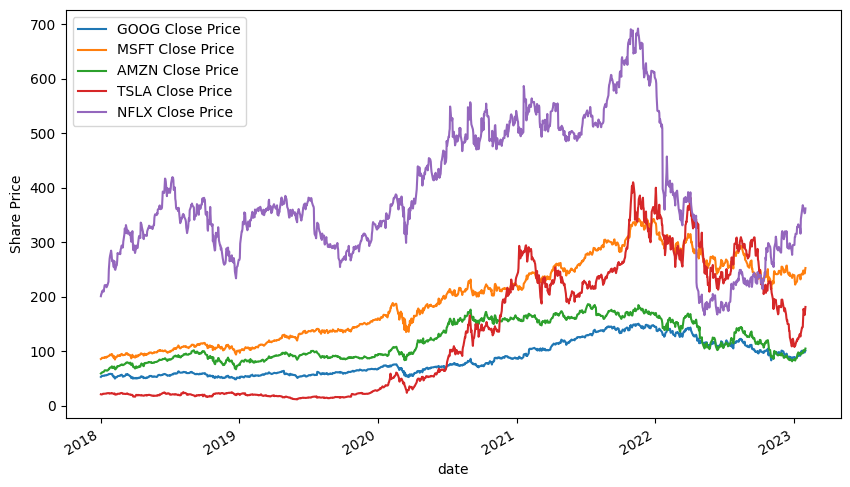

In [7]:
#EDA and summary stats for compiled datasets
ticker_list = ['GOOG', 'MSFT','AMZN','TSLA','NFLX']
plt.figure(figsize = (10, 6))
frames = [goog, msft, amzn, tesla, nflx]
#create plot to display change in share price
for i, frame in enumerate(frames):
  frame['close'].plot(label = ticker_list[i]+' Close Price')
plt.ylabel('Share Price')
plt.legend()
plt.show()



## 3.3 Scale Data and Configure Training/Test Datasets 

In [8]:
from sklearn.preprocessing import MinMaxScaler
# drop irrevelant columns
data = frames[1] # data for microsoft
data = data.drop(['ticker'],axis=1)
 
# features and target columns
target_scaler = MinMaxScaler()
target = target_scaler.fit_transform(data[['target']])
score = data['score']
X_feat = data.drop(['target', 'score'], axis = 1)

# Normalise the data
for col in X_feat.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    X_feat[col] = scaler.fit_transform(X_feat[[col]])
X_feat['score'] = score
X_ft = np.array(X_feat)
# Creating a data structure with 10 time-steps and 1 output
 
# Split data into X_train and y_train data sets
def lstm_split(data,target,steps):
  X = []
  y = []
  # Creating a data structure with 10 time-steps and 1 output
  for i in range(10, steps):
      X.append(data[i-10:i])
      y.append(target[i])  
  return np.array(X),np.array(y)
 
X1,y1 = lstm_split(X_feat,target,len(X_ft))
 

 # function to split  data 90% training-10% testing
def train_split(x1, y1, train_data):
  split = 0.9
  split_idx = int(np.ceil(len(X1)*split))
  date_index = train_data.index
 
  X_train,X_test = X1[:split_idx],X1[split_idx:]
  y_train,y_test = y1[:split_idx],y1[split_idx:]
  X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
  return X_train, X_test, y_train, y_test
  
X_train, X_test, y_train, y_test = train_split(X1, y1, frames[1])
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

(1270, 10, 18) (1143, 10, 18) (127, 10, 18) (127, 1) (1143, 1)


# 4.0 Single Company Model Implementation

This section contains the necessary code to define our model and train/test the standalone LSTM as well as the hybrid ensemble model. 

## 4.1 Build  & Validate the LSTM Model on Microsoft Stock
The general architecture of the model is available below. Specific hyperparameters will be defined during the training process using RandomSearch.

In [9]:
#LSTM Framework for MSFT
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
!pip install keras_tuner
import keras_tuner


#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
EPOCH = 200
BATCH = 24
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['mean_squared_error'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective= keras_tuner.Objective('val_loss', direction='min'), max_trials = 50, seed = 2)

#complete training 
tune.search(X_train, y_train, epochs = EPOCH, batch_size = BATCH, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]

#validating the training
test_predictions = LSTM_model.evaluate(X_train, y_train)
print(test_predictions)
LSTM_model.save('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5')
hyperparameters = tune.get_best_hyperparameters(1)[0]
print(hyperparameters.values)

Trial 50 Complete [00h 00m 30s]
val_loss: 0.019580965861678123

Best val_loss So Far: 0.0008706485969014466
Total elapsed time: 00h 32m 47s
36/36 [==============================] - 1s 4ms/step - loss: 6.4052e-04 - mean_squared_error: 6.4052e-04
[0.000640522746834904, 0.000640522746834904]
{'n_hidden': 0, 'neurons_visible': 98, 'activate1': 'sigmoid', 'dropout1': 0.4, 'neurons_hidden1': 20, 'dropout2': 0.7, 'neurons_hidden2': 50, 'dropout3': 0.1, 'neurons_hidden3': 50}


##4.2 LSTM Model Testing

### 4.2.2 Evaluate LSTM Model Success on MSFT Test Data

In [10]:
# function to test LSTM predictions
def testmodel(m_path, trainset ):
  from keras.models import load_model
  model = load_model(m_path)
  return model.predict(trainset)


4/4 [==============================] - 0s 10ms/step


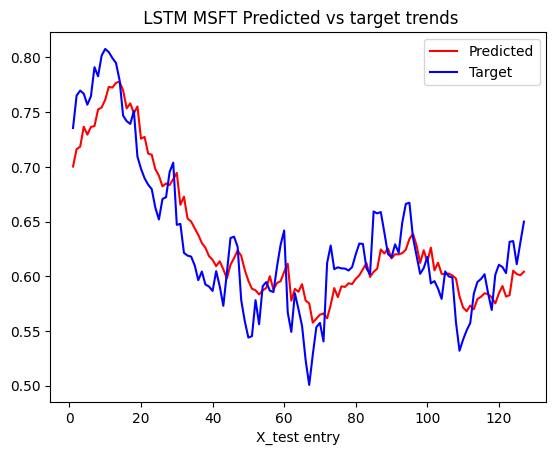

In [11]:
#test LSTM model using X_train for MSFT
LSTM_MSFT_test = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_test)
LSTM_MSFT_test.shape

import matplotlib.pyplot as plt
x=np.arange(1,len(y_test)+1, 1)
plt.plot(x,LSTM_MSFT_test.flatten(), "r", label= "Predicted")
plt.plot(x,y_test, "b", label= "Target")

plt.title(" LSTM MSFT Predicted vs target trends")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

### 4.2.1 Format Test Data to Reflect Training Data for Google Stock

In [12]:
# prep google test data
google = frames[0]
google_scaler = MinMaxScaler()
google_target = google_scaler.fit_transform(google[['target']])
google_score = google['score']
test_ft = google.drop(['target', 'score', 'ticker'], axis = 1)

# Normalise the data
for col in test_ft.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    test_ft[col] = scaler.fit_transform(test_ft[[col]])
test_ft['score'] = google_score
test_ft = np.array(test_ft)

google_ft, google_target = lstm_split(test_ft,google_target,len(test_ft))

In [13]:
#test LSTM model using X_train for GOOG
LSTM_GOOG_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', google_ft)
LSTM_GOOG_yhat.shape

40/40 [==============================] - 0s 5ms/step


(1270, 1)

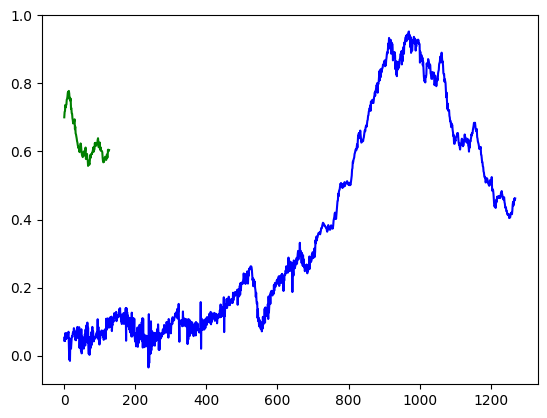

In [14]:
# compare LSTM on trained on MSFT on predictions for Google
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_test, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()




##4.3 Prophet Model



For this section is how we gonna fit the prophet model by using miscosoft company stock price data. The best hyperparameter we get by using the cross-validation

In [15]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

In [16]:
# Uploaded stock price csv
finance_data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Finance Data/finance.csv')
finance_data.head()

,date,open,high,low,close,adj_close,volume,ticker,10mda,20mda,50mda,100mda,target,EWMA_20,EWMA_50,EWMA_100,rsi,MiddleBand,UpperBand,LowerBand
0,2017-08-04,72.400002,73.040001,72.239998,72.680000,67.571640,22579000,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-07,72.800003,72.900002,72.260002,72.400002,67.311348,18705700,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-08,72.089996,73.129997,71.750000,72.790001,67.673927,22044600,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-09,72.250000,72.510002,72.050003,72.470001,67.376427,22213400,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-10,71.900002,72.190002,71.349998,71.410004,66.390930,24734500,MSFT,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
MSFT_Data = finance_data[finance_data['ticker']=='MSFT']
Google_Data = finance_data[finance_data['ticker']=='GOOG']
# This function is used to get the train data and test data
def data_preparation(df):
  data=df[["date","adj_close"]]
  data = data.rename(columns = {'date':'ds', 'adj_close':'y'})
  return data


In [ ]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(data_preparation(MSFT_Data))

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

### 4.3.1 Forecasting with Prophet

In [18]:
def get_data(df):
  Best_parameters={'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
  # We use the best parameter to fit the model
  final_model = Prophet(**Best_parameters)
  final_model.fit(data_preparation(df))
  df = cross_validation(model=final_model, initial='124 days', horizon='10 days', period='10 days')
  return df

In [19]:
MSFT_train_data = get_data(MSFT_Data)[['ds', 'yhat']]
MSFT_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5q8cqil/7fjehb6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5q8cqil/d1_0e73a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19165', 'data', 'file=/tmp/tmpb5q8cqil/7fjehb6v.json', 'init=/tmp/tmpb5q8cqil/d1_0e73a.json', 'output', 'file=/tmp/tmpb5q8cqil/prophet_model2drll_2z/prophet_model-20230413204917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:49:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:49:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5q8cqil/d78hcxwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5q8cqil/srfuxhes.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35835', 'data', 'file=/tmp/tmpb5q8cqil/d78hcxwy.json', 'init=/tmp/tmpb5q8cqil/srfuxhes.json', 'output', 'file=/tmp/tmpb5q8cqil/prophet_modelzefzhvuj/prophet_model-20230413204923.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:49:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5q8cqil/hw49p1uf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5q8cqil/mgsgm4x7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,73.970595
1,2017-12-19,68.597337
2,2017-12-20,60.279245
3,2017-12-21,49.091784
4,2017-12-22,34.894607


In [20]:
Google_train_data = get_data(Google_Data)[['ds', 'yhat']]
Google_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5q8cqil/6mc403sg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5q8cqil/r6ptb4t_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65371', 'data', 'file=/tmp/tmpb5q8cqil/6mc403sg.json', 'init=/tmp/tmpb5q8cqil/r6ptb4t_.json', 'output', 'file=/tmp/tmpb5q8cqil/prophet_modell6z4mcw7/prophet_model-20230413205511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5q8cqil/blc50nji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5q8cqil/bi41ikvg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15522', 'data', 'file=/tmp/tmpb5q8cqil/blc50nji.json', 'init=/tmp/tmpb5q8cqil/bi41ikvg.json', 'output', 'file=/tmp/tmpb5q8cqil/prophet_modelkj_n7dbg/prophet_model-20230413205513.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:55:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5q8cqil/vgzl4o4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5q8cqil/8l4bh6vj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,53.406188
1,2017-12-19,53.607782
2,2017-12-20,53.609407
3,2017-12-21,53.306160
4,2017-12-22,52.961331


In [70]:
def prep_prophet(prophet_pred, data1):
  prophet_pred = prophet_pred.rename(columns = {'ds': 'date'}).set_index('date')
  main_data = data1.join(prophet_pred,how = 'left')
  returned = main_data.loc['2018-01-01':'2023-02-01', 'yhat']
  return returned

goog_data = prep_prophet(Google_train_data, frames[0])[10:]
msft_train_data = prep_prophet(MSFT_train_data, frames[1])[10:1153]
msft_test_data = prep_prophet(MSFT_train_data, frames[1])[1153:]
print(msft_train_data)

date
2018-01-17     83.052493
2018-01-18     82.736963
2018-01-19     82.888275
2018-01-22     80.861980
2018-01-23     80.118403
                 ...    
2022-07-26    257.094632
2022-07-27    257.573531
2022-07-28    257.069892
2022-07-29    257.239474
2022-08-01    256.624893
Name: yhat, Length: 1143, dtype: float64


##4.4 Hybrid Model 

 ### 4.4.1 Define Training Data Using Ouputs from Standalone Models MSFT

In [22]:
#creating y_hybrid from y_train of the LSTM model
print(y_train.shape)
y_hybrid= y_train
print(y_train.shape, y_hybrid.shape)
print(goog_data.shape)

(1143, 1)
(1143, 1) (1143, 1)
(1270,)


In [23]:
#verifying that outputs from both the LSTM and Prohet models match in size
LSTM_MSFT_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_train)
print ("LSTM:", LSTM_MSFT_yhat.shape,"\n","Prophet:", msft_train_data.shape)

#merging the the outcomes from the LSTM model and the Prophet model

msft_hybrid = { 'LSTM':LSTM_MSFT_yhat.flatten(), 'prophet':np.array(msft_train_data), }
msft_hybrid_df = pd.DataFrame(msft_hybrid)

#scaling the MSFT_PROPHET column
scaler2 = MinMaxScaler()
msft_hybrid_df['prophet'] = scaler2.fit_transform(msft_hybrid_df[['prophet']])

#Defining the data for the hybrid training
X2_ft = np.array(msft_hybrid_df)
print("y_hybrid", y_hybrid.shape)

X_train2,y_train2 = lstm_split(msft_hybrid_df,y_hybrid,len(msft_hybrid_df))


36/36 [==============================] - 0s 4ms/step
LSTM: (1143, 1) 
 Prophet: (1143,)
y_hybrid (1143, 1)


In [24]:
#LSTM Framework for the hybrid model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
import keras_tuner


#Hybrid model architecture and training
LR = 0.01
EPOCH = 300
BATCH = 24
hybrid = Sequential()
hybrid.add(LSTM(units = 98, activation = "sigmoid", input_shape = (X_train2.shape[1], X_train2.shape[2]), return_sequences = False))
hybrid.add(Dropout(0.5))
hybrid.add(Dense(units =1))
hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mae"])
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

hybrid_history = hybrid.fit(X_train2, y_train2, epochs = EPOCH, batch_size = BATCH, callbacks = [Early_stop])

hybrid_history.model.save('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5')

Epoch 1/300


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


48/48 [==============================] - 2s 9ms/step - loss: 0.2415 - mae: 0.3710
Epoch 2/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0762 - mae: 0.2236
Epoch 3/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0447 - mae: 0.1686
Epoch 4/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0273 - mae: 0.1329
Epoch 5/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0183 - mae: 0.1056
Epoch 6/300
48/48 [==============================] - 1s 13ms/step - loss: 0.0131 - mae: 0.0905
Epoch 7/300
48/48 [==============================] - 1s 13ms/step - loss: 0.0111 - mae: 0.0826
Epoch 8/300
48/48 [==============================] - 1s 13ms/step - loss: 0.0091 - mae: 0.0732
Epoch 9/300
48/48 [==============================] - 1s 13ms/step - loss: 0.0081 - mae: 0.0684
Epoch 10/300
48/48 [==============================] - 1s 14ms/step - loss: 0.0067 - mae: 0.0628
Epoch 11/300
48/48 [==============================] - 1s 14ms/step

###4.4.2 LOSS and MAE

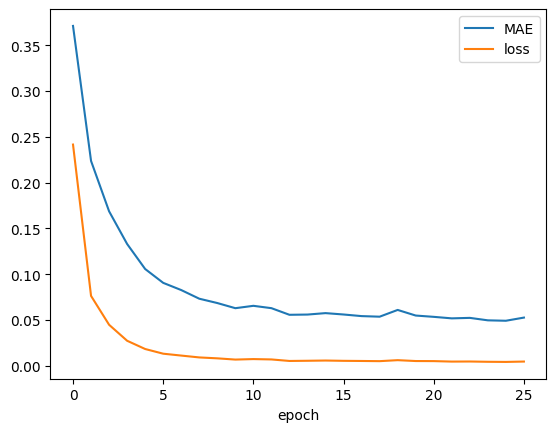

In [25]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### 4.4.3 Comparing output of LSTM MSFT and Hybrid MSFT 

###4.4.4 Hybrid Model Testing on GOOG

In [26]:
#merge lstm test prediction and prophet test prediction
def merge_predictions(lstm_pred,prophet_pred):
  data_dict = {}
  scaler = MinMaxScaler()
  data_dict['LSTM'] = lstm_pred.flatten()
  data_dict['prophet'] = np.array(prophet_pred)
  hybrid_test_data = pd.DataFrame(data_dict)
  hybrid_test_data['prophet'] = scaler.fit_transform(hybrid_test_data[['prophet']])
  return hybrid_test_data

In [27]:
from keras.models import load_model
MSFT_test_hybrid = merge_predictions(LSTM_MSFT_test, msft_test_data)
MSFT_x_test, MSFT_y_test = lstm_split(MSFT_test_hybrid, y_test, len(MSFT_test_hybrid))
MSFT_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', MSFT_x_test)

4/4 [==============================] - 0s 5ms/step


In [28]:
print(LSTM_GOOG_yhat.shape,goog_data.shape)
GOOG_test_hybrid= merge_predictions(LSTM_GOOG_yhat, goog_data)
GOOG_x_test, GOOG_y_test = lstm_split(GOOG_test_hybrid,google_target,len(GOOG_test_hybrid))
GOOG_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', GOOG_x_test)


(1270, 1) (1270,)
40/40 [==============================] - 0s 3ms/step


In [29]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    rmse = tf.keras.metrics.RootMeanSquaredError()
    rmse.update_state(true_series, forecast)
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true_series, forecast)
    print(f"the root mean square error of the predictions is {rmse.result().numpy()}, and the mean absolute error of the predictions is {mae.result().numpy()}")
    return rmse.result().numpy(), mae.result().numpy()

In [52]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(msft_hybrid_df,y_hybrid)
linear_predictions_GOOG = linear_model.predict(GOOG_test_hybrid)
linear_predictions_MSFT = linear_model.predict(MSFT_test_hybrid)
print(linear_predictions_GOOG[1:10])
print(GOOG_y_test[1:10])

[[0.05218404]
 [0.04001355]
 [0.06304235]
 [0.04597699]
 [0.05910697]
 [0.04789958]
 [0.06354978]
 [0.06494795]
 [0.0514194 ]]
[[0.09395668]
 [0.06657638]
 [0.03904885]
 [0.05121787]
 [0.0355061 ]
 [0.01241437]
 [0.03020667]
 [0.0371548 ]
 [0.0372333 ]]


###4.4.5 Predicted vs Actual Price

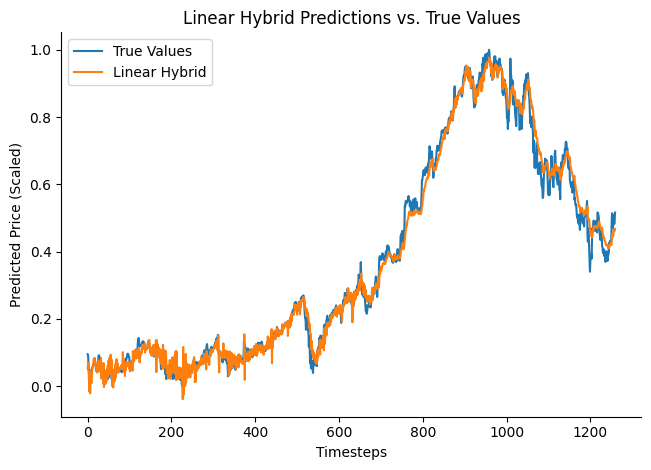

In [31]:

plt.plot(GOOG_y_test, label="True Values")
plt.plot(linear_predictions_GOOG[10:], label="Linear Hybrid")
#plt.plot(GOOG_predictions, label="LSTM Hybrid")
plt.xlabel("Timesteps")
plt.ylabel("Predicted Price (Scaled)")
plt.title('Linear Hybrid Predictions vs. True Values')
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show()

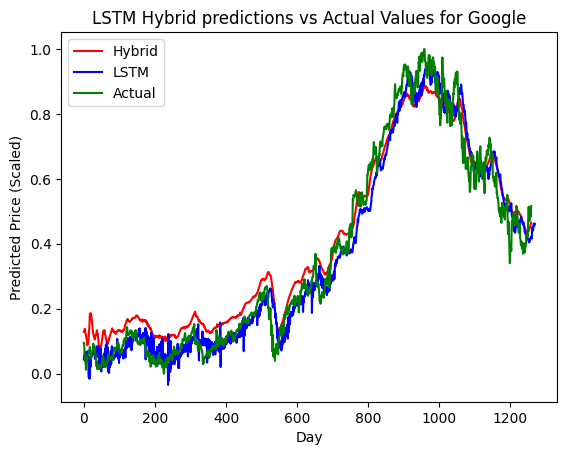

In [32]:
import matplotlib.pyplot as plt
x=np.arange(1,len(GOOG_y_test)+1, 1)
plt.plot(GOOG_predictions.flatten(), "r", label= "Hybrid")
plt.plot(LSTM_GOOG_yhat, "b", label= "LSTM")
plt.plot(GOOG_y_test, "g", label= "Actual")

plt.title("LSTM Hybrid predictions vs Actual Values for Google")
plt.xlabel('Day')
plt.ylabel("Predicted Price (Scaled)")
plt.legend()
plt.show()

## Return Predictions to Original Scale for Final Analysis

In [ ]:
GOOG_scaler = 
MSFT_scaler = 

#5.0 Multiple Company Model

## 5.1 Generate Sub-models

In [33]:
def create_lists(list_of_df):
  training_list = []
  target_list = []
  for i in range(len(list_of_df)):
    scaler = MinMaxScaler()
    data = list_of_df[i]
    score = data['score']
    target = scaler.fit_transform(data[['target']])
    training = data.drop(['target', 'ticker', 'score'], axis = 1)
    for col in training.columns:
      training[col] = scaler.fit_transform(training[[col]])
    training['score'] = score
    data_x, data_y = lstm_split(training, target, len(training))
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 98, activation = "relu", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.7))
    hybrid.add(Dense(units =1, activation = 'sigmoid'))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mean_squared_error"])
    Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 200, batch_size = 24, callbacks = [Early_stop])
    return hybrid

training_list, target_list = create_lists(frames[1:])
for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(x_train, y_train)
  model.save('/content/StockPrice-Hybrid-Model-/sub_models/'+tick+'_lstm.h5')


Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


53/53 [==============================] - ETA: 0s - loss: 0.0164 - mean_squared_error: 0.0164

53/53 [==============================] - 2s 9ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 2/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 3/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 4/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 5/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 6/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 7/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 8/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 9/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 14ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 10/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 11/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 12/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 13/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 15/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 16/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 17/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 18/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 19/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 20/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 21/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 22/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 23/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 24/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 25/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 26/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 27/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 28/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 29/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 30/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 31/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 33/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 34/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 35/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 36/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 37/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 39/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 40/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 41/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 42/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 43/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 44/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 45/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 46/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 47/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 48/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 49/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 50/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 51/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 52/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 53/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 54/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 55/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 56/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 57/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 58/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 59/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 60/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 61/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 62/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 63/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 64/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 65/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 66/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 67/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 68/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 69/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 70/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 71/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 72/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 73/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 74/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 75/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 76/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 77/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 78/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 79/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 80/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 81/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 82/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 83/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 84/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 85/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 86/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 87/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 88/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 89/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 90/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 91/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 92/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 93/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 94/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 95/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 96/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 97/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 98/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 99/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 100/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 101/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 102/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 103/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 104/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 105/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 106/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 107/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 108/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 109/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 110/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 111/200
52/53 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 112/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 113/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 114/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 115/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 116/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 117/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 118/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 119/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 120/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 121/200
52/53 [============================>.] - ETA: 0s - loss: 0.0120 - mean_squared_error: 0.0120

53/53 [==============================] - 1s 9ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 122/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0192 - mean_squared_error: 0.0192

53/53 [==============================] - 1s 10ms/step - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 123/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0189 - mean_squared_error: 0.0189

53/53 [==============================] - 1s 9ms/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 124/200
52/53 [============================>.] - ETA: 0s - loss: 0.0182 - mean_squared_error: 0.0182

53/53 [==============================] - 1s 10ms/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 125/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0198 - mean_squared_error: 0.0198

53/53 [==============================] - 1s 10ms/step - loss: 0.0200 - mean_squared_error: 0.0200
Epoch 126/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0158 - mean_squared_error: 0.0158

53/53 [==============================] - 1s 10ms/step - loss: 0.0155 - mean_squared_error: 0.0155
Epoch 127/200
53/53 [==============================] - ETA: 0s - loss: 0.0148 - mean_squared_error: 0.0148

53/53 [==============================] - 1s 10ms/step - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 128/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0165 - mean_squared_error: 0.0165

53/53 [==============================] - 1s 10ms/step - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 129/200
52/53 [============================>.] - ETA: 0s - loss: 0.0119 - mean_squared_error: 0.0119

53/53 [==============================] - 1s 10ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 130/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0123 - mean_squared_error: 0.0123

53/53 [==============================] - 1s 10ms/step - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 131/200
53/53 [==============================] - ETA: 0s - loss: 0.0104 - mean_squared_error: 0.0104

53/53 [==============================] - 1s 9ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 132/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0186 - mean_squared_error: 0.0186

53/53 [==============================] - 1s 10ms/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 133/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0137 - mean_squared_error: 0.0137

53/53 [==============================] - 1s 10ms/step - loss: 0.0136 - mean_squared_error: 0.0136
Epoch 134/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0118 - mean_squared_error: 0.0118

53/53 [==============================] - 0s 9ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 135/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0133 - mean_squared_error: 0.0133

53/53 [==============================] - 1s 9ms/step - loss: 0.0134 - mean_squared_error: 0.0134
Epoch 136/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0119 - mean_squared_error: 0.0119

53/53 [==============================] - 1s 10ms/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 137/200
52/53 [============================>.] - ETA: 0s - loss: 0.0114 - mean_squared_error: 0.0114

53/53 [==============================] - 1s 10ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 138/200
52/53 [============================>.] - ETA: 0s - loss: 0.0109 - mean_squared_error: 0.0109

53/53 [==============================] - 1s 10ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 139/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

53/53 [==============================] - 1s 10ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 140/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

53/53 [==============================] - 1s 14ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 141/200
53/53 [==============================] - ETA: 0s - loss: 0.0103 - mean_squared_error: 0.0103

53/53 [==============================] - 1s 14ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 142/200
53/53 [==============================] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

53/53 [==============================] - 1s 14ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 143/200
53/53 [==============================] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

53/53 [==============================] - 1s 14ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 144/200
52/53 [============================>.] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

53/53 [==============================] - 1s 15ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 145/200
53/53 [==============================] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

53/53 [==============================] - 1s 14ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 146/200
52/53 [============================>.] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

53/53 [==============================] - 1s 13ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 147/200
53/53 [==============================] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

53/53 [==============================] - 1s 10ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 148/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

53/53 [==============================] - 1s 10ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 149/200
53/53 [==============================] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

53/53 [==============================] - 1s 10ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 150/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

53/53 [==============================] - 1s 10ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 151/200
52/53 [============================>.] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

53/53 [==============================] - 1s 10ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 152/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

53/53 [==============================] - 1s 10ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 153/200
53/53 [==============================] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

53/53 [==============================] - 1s 10ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 154/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.0086

53/53 [==============================] - 1s 10ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 155/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0083 - mean_squared_error: 0.0083

53/53 [==============================] - 1s 10ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 156/200
53/53 [==============================] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

53/53 [==============================] - 1s 10ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 157/200
52/53 [============================>.] - ETA: 0s - loss: 0.0093 - mean_squared_error: 0.0093

53/53 [==============================] - 1s 10ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 158/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

53/53 [==============================] - 1s 10ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 159/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.0086

53/53 [==============================] - 1s 10ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 160/200
52/53 [============================>.] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

53/53 [==============================] - 1s 10ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 161/200
52/53 [============================>.] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

53/53 [==============================] - 1s 10ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 162/200
52/53 [============================>.] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

53/53 [==============================] - 1s 10ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 163/200
52/53 [============================>.] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

53/53 [==============================] - 1s 10ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 164/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

53/53 [==============================] - 1s 10ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 165/200
53/53 [==============================] - ETA: 0s - loss: 0.0122 - mean_squared_error: 0.0122

53/53 [==============================] - 1s 14ms/step - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 166/200
52/53 [============================>.] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

53/53 [==============================] - 1s 14ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 167/200
52/53 [============================>.] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

53/53 [==============================] - 1s 14ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 168/200
53/53 [==============================] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

53/53 [==============================] - 1s 14ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 169/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

53/53 [==============================] - 1s 14ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 170/200
52/53 [============================>.] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

53/53 [==============================] - 1s 14ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 171/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0103 - mean_squared_error: 0.0103

53/53 [==============================] - 1s 14ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 172/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

53/53 [==============================] - 0s 9ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 173/200
53/53 [==============================] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.0107

53/53 [==============================] - 1s 10ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 174/200
52/53 [============================>.] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

53/53 [==============================] - 1s 10ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 175/200
52/53 [============================>.] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

53/53 [==============================] - 1s 10ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 176/200
53/53 [==============================] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

53/53 [==============================] - 1s 10ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 177/200
53/53 [==============================] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

53/53 [==============================] - 1s 10ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 178/200
53/53 [==============================] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

53/53 [==============================] - 1s 10ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 179/200
52/53 [============================>.] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.0107

53/53 [==============================] - 1s 10ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 180/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0105 - mean_squared_error: 0.0105

53/53 [==============================] - 1s 10ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 181/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0087 - mean_squared_error: 0.0087

53/53 [==============================] - 1s 10ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 182/200
52/53 [============================>.] - ETA: 0s - loss: 0.0109 - mean_squared_error: 0.0109

53/53 [==============================] - 1s 10ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 183/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.0086

53/53 [==============================] - 1s 10ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 184/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_squared_error: 0.0093

53/53 [==============================] - 1s 10ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 185/200
53/53 [==============================] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.0099

53/53 [==============================] - 1s 10ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 186/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

53/53 [==============================] - 1s 10ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 187/200
52/53 [============================>.] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

53/53 [==============================] - 1s 10ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 188/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

53/53 [==============================] - 1s 10ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 189/200
52/53 [============================>.] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

53/53 [==============================] - 1s 10ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 190/200
52/53 [============================>.] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0115

53/53 [==============================] - 1s 11ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 191/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0183 - mean_squared_error: 0.0183

53/53 [==============================] - 1s 14ms/step - loss: 0.0180 - mean_squared_error: 0.0180
Epoch 192/200
53/53 [==============================] - ETA: 0s - loss: 0.0161 - mean_squared_error: 0.0161

53/53 [==============================] - 1s 14ms/step - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 193/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0146 - mean_squared_error: 0.0146

53/53 [==============================] - 1s 14ms/step - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.0120 - mean_squared_error: 0.0120

53/53 [==============================] - 1s 15ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 195/200
53/53 [==============================] - ETA: 0s - loss: 0.0184 - mean_squared_error: 0.0184

53/53 [==============================] - 1s 14ms/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 196/200
52/53 [============================>.] - ETA: 0s - loss: 0.0212 - mean_squared_error: 0.0212

53/53 [==============================] - 1s 14ms/step - loss: 0.0213 - mean_squared_error: 0.0213
Epoch 197/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0187 - mean_squared_error: 0.0187

53/53 [==============================] - 1s 13ms/step - loss: 0.0186 - mean_squared_error: 0.0186
Epoch 198/200
52/53 [============================>.] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.0170

53/53 [==============================] - 1s 10ms/step - loss: 0.0169 - mean_squared_error: 0.0169
Epoch 199/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0158 - mean_squared_error: 0.0158

53/53 [==============================] - 1s 10ms/step - loss: 0.0156 - mean_squared_error: 0.0156
Epoch 200/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.0117

53/53 [==============================] - 1s 10ms/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 1/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0201 - mean_squared_error: 0.0201

53/53 [==============================] - 2s 9ms/step - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 2/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0087 - mean_squared_error: 0.0087

53/53 [==============================] - 1s 10ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 3/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

53/53 [==============================] - 1s 10ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 4/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

53/53 [==============================] - 1s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 5/200
52/53 [============================>.] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

53/53 [==============================] - 1s 10ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 6/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 10ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 7/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.0086

53/53 [==============================] - 1s 10ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 8/200
52/53 [============================>.] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 10ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 9/200
52/53 [============================>.] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 1s 10ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 10/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

53/53 [==============================] - 1s 10ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 11/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 12/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 13/200
52/53 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 14/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 15/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 16/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 17/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 18/200
53/53 [==============================] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 14ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 19/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 14ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 20/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 21/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 22/200
52/53 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 10ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 23/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 24/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 25/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 26/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 27/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 28/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 29/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 30/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 31/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 33/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 34/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 35/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 36/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 37/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 38/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 10ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 39/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 40/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 41/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 42/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 43/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 44/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 45/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 46/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 47/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 48/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 49/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 50/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 51/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 52/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 53/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 54/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 55/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 56/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 57/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 58/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 59/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 60/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 61/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 62/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 63/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 64/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 65/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 66/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 67/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 68/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 14ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 69/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 13ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 70/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 14ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 71/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 14ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 72/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 14ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 73/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 74/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 75/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 76/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 77/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 78/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 79/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 80/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 81/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 82/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 83/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 84/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 85/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 86/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 87/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 88/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 89/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 90/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 91/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 92/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 14ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 93/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 13ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 94/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 95/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 96/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 14ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 97/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 98/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 99/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 100/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 101/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 102/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 103/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 104/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 105/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 106/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 107/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 108/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 109/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 110/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 111/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 112/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 113/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 114/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 115/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 116/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 117/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 118/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 119/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 120/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 13ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 121/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 122/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 123/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 124/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 125/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 127/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 128/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 129/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 130/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 131/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 132/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 133/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 134/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 135/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 136/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 137/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 10ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 138/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 139/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 140/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 141/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 142/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 143/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 144/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 145/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 146/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 147/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 14ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 148/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 149/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 14ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 150/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 14ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 151/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 152/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 153/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 154/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 155/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 156/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 157/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 158/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 159/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 160/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 161/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 162/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 163/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 164/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 165/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 166/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 167/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 168/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 169/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 170/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 171/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 13ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 172/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 173/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 174/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 175/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 13ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 176/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 17ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 177/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 178/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 179/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 180/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 181/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 182/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 1s 10ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 183/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 10ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 184/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 185/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 186/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 187/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 188/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 189/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 190/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 191/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 192/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 193/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 195/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 196/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 14ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 197/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 198/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 13ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 199/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 200/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 14ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 1/200
53/53 [==============================] - ETA: 0s - loss: 0.0187 - mean_squared_error: 0.0187

53/53 [==============================] - 2s 10ms/step - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 2/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

53/53 [==============================] - 1s 10ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 3/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 1s 10ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 4/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 5/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 6/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 7/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 8/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 9/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 10/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 11/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 12/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 13/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 14/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 15/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 16/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 17/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 18/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 19/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 20/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 21/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 22/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 23/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 24/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 25/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 26/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 27/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 28/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 29/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 30/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 31/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 33/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 34/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 35/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 36/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 37/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 39/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 40/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 41/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 42/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 43/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 44/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 45/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 46/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 47/200
52/53 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 15ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 48/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 49/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 50/200
53/53 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 51/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 52/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 53/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 54/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 55/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 56/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 57/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 58/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 59/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 60/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 61/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 62/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 63/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 64/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 65/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 66/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 67/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 68/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 69/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 70/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 71/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 72/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 73/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 74/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 75/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 76/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 77/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 78/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 79/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 80/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 81/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 82/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 83/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 84/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 85/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 86/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 87/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 88/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 89/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 90/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 91/200
53/53 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 92/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 93/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 94/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 95/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 96/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 97/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 98/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 99/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 100/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 101/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 102/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 103/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 104/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 105/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 14ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 106/200
52/53 [============================>.] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 107/200
53/53 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 108/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 109/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 110/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 111/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 112/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 113/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 114/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 115/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 116/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 117/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 118/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 119/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 120/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 121/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 122/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 123/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 124/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 125/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 15ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 127/200
52/53 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 15ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 128/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 129/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 130/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 131/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 15ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 132/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 133/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 134/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 135/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 136/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 137/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 138/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0104 - mean_squared_error: 0.0104

53/53 [==============================] - 1s 10ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 139/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0408 - mean_squared_error: 0.0408

53/53 [==============================] - 1s 10ms/step - loss: 0.0405 - mean_squared_error: 0.0405
Epoch 140/200
52/53 [============================>.] - ETA: 0s - loss: 0.0145 - mean_squared_error: 0.0145

53/53 [==============================] - 1s 11ms/step - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 141/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0203 - mean_squared_error: 0.0203

53/53 [==============================] - 1s 11ms/step - loss: 0.0201 - mean_squared_error: 0.0201
Epoch 142/200
53/53 [==============================] - ETA: 0s - loss: 0.0145 - mean_squared_error: 0.0145

53/53 [==============================] - 1s 10ms/step - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 143/200
52/53 [============================>.] - ETA: 0s - loss: 0.0147 - mean_squared_error: 0.0147

53/53 [==============================] - 1s 11ms/step - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 144/200
53/53 [==============================] - ETA: 0s - loss: 0.0151 - mean_squared_error: 0.0151

53/53 [==============================] - 1s 13ms/step - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 145/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

53/53 [==============================] - 1s 11ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 146/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0130 - mean_squared_error: 0.0130

53/53 [==============================] - 1s 11ms/step - loss: 0.0134 - mean_squared_error: 0.0134
Epoch 147/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0255 - mean_squared_error: 0.0255

53/53 [==============================] - 1s 10ms/step - loss: 0.0277 - mean_squared_error: 0.0277
Epoch 148/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0245 - mean_squared_error: 0.0245

53/53 [==============================] - 1s 11ms/step - loss: 0.0246 - mean_squared_error: 0.0246
Epoch 149/200
53/53 [==============================] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.0213

53/53 [==============================] - 1s 12ms/step - loss: 0.0213 - mean_squared_error: 0.0213
Epoch 150/200
53/53 [==============================] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.0213

53/53 [==============================] - 1s 14ms/step - loss: 0.0213 - mean_squared_error: 0.0213
Epoch 151/200
53/53 [==============================] - ETA: 0s - loss: 0.0226 - mean_squared_error: 0.0226

53/53 [==============================] - 1s 16ms/step - loss: 0.0226 - mean_squared_error: 0.0226
Epoch 152/200
52/53 [============================>.] - ETA: 0s - loss: 0.0195 - mean_squared_error: 0.0195

53/53 [==============================] - 1s 13ms/step - loss: 0.0193 - mean_squared_error: 0.0193
Epoch 153/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0163 - mean_squared_error: 0.0163

53/53 [==============================] - 1s 13ms/step - loss: 0.0160 - mean_squared_error: 0.0160
Epoch 154/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0137 - mean_squared_error: 0.0137

53/53 [==============================] - 1s 16ms/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 155/200
52/53 [============================>.] - ETA: 0s - loss: 0.0133 - mean_squared_error: 0.0133

53/53 [==============================] - 1s 15ms/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 156/200
52/53 [============================>.] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.0127

53/53 [==============================] - 1s 15ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 157/200
53/53 [==============================] - ETA: 0s - loss: 0.0134 - mean_squared_error: 0.0134

53/53 [==============================] - 1s 14ms/step - loss: 0.0134 - mean_squared_error: 0.0134
Epoch 158/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0135 - mean_squared_error: 0.0135

53/53 [==============================] - 1s 11ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 159/200
52/53 [============================>.] - ETA: 0s - loss: 0.0123 - mean_squared_error: 0.0123

53/53 [==============================] - 1s 11ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 160/200
53/53 [==============================] - ETA: 0s - loss: 0.0122 - mean_squared_error: 0.0122

53/53 [==============================] - 1s 11ms/step - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 161/200
52/53 [============================>.] - ETA: 0s - loss: 0.0138 - mean_squared_error: 0.0138

53/53 [==============================] - 1s 11ms/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 162/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0129 - mean_squared_error: 0.0129

53/53 [==============================] - 1s 11ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 163/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0120 - mean_squared_error: 0.0120

53/53 [==============================] - 1s 11ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 164/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0112 - mean_squared_error: 0.0112

53/53 [==============================] - 1s 11ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 165/200
52/53 [============================>.] - ETA: 0s - loss: 0.0131 - mean_squared_error: 0.0131

53/53 [==============================] - 1s 11ms/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 166/200
52/53 [============================>.] - ETA: 0s - loss: 0.0125 - mean_squared_error: 0.0125

53/53 [==============================] - 1s 11ms/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 167/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0113 - mean_squared_error: 0.0113

53/53 [==============================] - 1s 10ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 168/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.0107

53/53 [==============================] - 1s 10ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 169/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0125 - mean_squared_error: 0.0125

53/53 [==============================] - 1s 10ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 170/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.0108

53/53 [==============================] - 1s 12ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 171/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.0108

53/53 [==============================] - 1s 11ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 172/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0119 - mean_squared_error: 0.0119

53/53 [==============================] - 1s 10ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 173/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.0108

53/53 [==============================] - 1s 11ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 174/200
53/53 [==============================] - ETA: 0s - loss: 0.0158 - mean_squared_error: 0.0158

53/53 [==============================] - 1s 11ms/step - loss: 0.0158 - mean_squared_error: 0.0158
Epoch 175/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0199 - mean_squared_error: 0.0199

53/53 [==============================] - 1s 14ms/step - loss: 0.0201 - mean_squared_error: 0.0201
Epoch 176/200
52/53 [============================>.] - ETA: 0s - loss: 0.0131 - mean_squared_error: 0.0131

53/53 [==============================] - 1s 14ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 177/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0122 - mean_squared_error: 0.0122

53/53 [==============================] - 1s 13ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 178/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0103 - mean_squared_error: 0.0103

53/53 [==============================] - 1s 13ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 179/200
52/53 [============================>.] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

53/53 [==============================] - 1s 13ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 180/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

53/53 [==============================] - 1s 15ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 181/200
52/53 [============================>.] - ETA: 0s - loss: 0.0093 - mean_squared_error: 0.0093

53/53 [==============================] - 1s 15ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 182/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0105 - mean_squared_error: 0.0105

53/53 [==============================] - 1s 15ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 183/200
52/53 [============================>.] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

53/53 [==============================] - 1s 16ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 184/200
53/53 [==============================] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.0102

53/53 [==============================] - 1s 13ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 185/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

53/53 [==============================] - 1s 11ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 186/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

53/53 [==============================] - 1s 10ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 187/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0111 - mean_squared_error: 0.0111

53/53 [==============================] - 1s 11ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 188/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.0101

53/53 [==============================] - 1s 10ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 189/200
53/53 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 11ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 190/200
52/53 [============================>.] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 11ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 191/200
53/53 [==============================] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 1s 11ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 192/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

53/53 [==============================] - 1s 10ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 193/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 194/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 195/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

53/53 [==============================] - 1s 11ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 196/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 197/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 1s 10ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 198/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 11ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 199/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 200/200
52/53 [============================>.] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 11ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 1/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0156 - mean_squared_error: 0.0156

53/53 [==============================] - 2s 14ms/step - loss: 0.0153 - mean_squared_error: 0.0153
Epoch 2/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

53/53 [==============================] - 1s 15ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 3/200
53/53 [==============================] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 14ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 4/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 5/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 15ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 6/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 7/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 8/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 9/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 10/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 11/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 12/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 13/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 15/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 16/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 17/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 18/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 19/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 20/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 21/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 22/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 23/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 24/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 25/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 26/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 27/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 28/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 29/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 30/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 31/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 32/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 14ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 33/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 34/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 35/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 36/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 37/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 38/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 39/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 40/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 41/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 42/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 43/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 44/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 45/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 46/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 47/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 48/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 49/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 50/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 51/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 52/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 53/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 54/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 55/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 56/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 57/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 58/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 59/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 60/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 61/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 62/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 63/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 64/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 65/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 66/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 67/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 68/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 69/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 70/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 71/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 72/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 73/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 74/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 75/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 76/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 77/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 78/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 79/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 80/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 81/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 82/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 83/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 15ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 84/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 85/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 86/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 87/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 88/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 89/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 90/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 91/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 92/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 93/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 94/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 95/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 96/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 97/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 98/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 99/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 100/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 101/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 102/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 103/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 15ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 104/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 105/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 106/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 107/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 108/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 109/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 110/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 111/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 112/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 113/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 114/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 115/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 116/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 117/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 118/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 119/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 120/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 121/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 122/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 123/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 124/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 125/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 127/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 128/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 129/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 130/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 131/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 132/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 133/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 134/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 135/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 136/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 137/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 138/200
53/53 [==============================] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

53/53 [==============================] - 1s 13ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 139/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0114 - mean_squared_error: 0.0114

53/53 [==============================] - 1s 11ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 140/200
53/53 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 141/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 142/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 143/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 144/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 145/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 146/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 147/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 148/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 149/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 150/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 151/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 152/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 153/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 154/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 155/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 156/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 157/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 13ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 158/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 14ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 159/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 160/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 161/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 162/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 163/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 164/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 15ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 165/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 166/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 167/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 168/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 169/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 170/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 171/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 172/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 173/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 174/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 175/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 176/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 177/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 178/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 179/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 180/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 181/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 182/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 15ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 183/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 184/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 185/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 186/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 187/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 188/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 16ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 189/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 190/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 191/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 14ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 192/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 193/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 194/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 195/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 196/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 197/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 198/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 199/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 200/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045


### 5.1.1 Configure Hybrid Training Set and Train Hybrid Model

In [34]:
import os

def hybrid_train(direct, ticker_list, hybrid_train, prophet, targets):
    preds_dict = {}
    path = direct
    scaler = MinMaxScaler()
    for num, model in enumerate(os.listdir(path)):
        model = load_model(path+model)
        prediction = model.predict(hybrid_train).flatten()
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DataFrame(preds_dict)
    preds_df['prophet'] = np.array(prophet)
    preds_df['prophet'] = scaler.fit_transform(preds_df[['prophet']])
    x1,y1 = lstm_split(preds_df, targets, len(preds_df))
    return x1, y1, preds_df, targets

ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_training_data, targets, preds_df, training_y =  hybrid_train('/content/StockPrice-Hybrid-Model-/sub_models/', ticker_list, X_train, msft_train_data, y_hybrid) 
hybrid_expanded = multiple_models(hybrid_training_data, targets)

36/36 [==============================] - 0s 4ms/step
Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


46/48 [===========================>..] - ETA: 0s - loss: 0.0208 - mean_squared_error: 0.0208

48/48 [==============================] - 2s 11ms/step - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 2/200
47/48 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

48/48 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 3/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

48/48 [==============================] - 1s 14ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 4/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

48/48 [==============================] - 1s 13ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 5/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

48/48 [==============================] - 1s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 6/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

48/48 [==============================] - 1s 13ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 7/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

48/48 [==============================] - 1s 13ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 8/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

48/48 [==============================] - 1s 13ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 9/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

48/48 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 10/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

48/48 [==============================] - 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 11/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

48/48 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 12/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

48/48 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 13/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

48/48 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 14/200
47/48 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

48/48 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 15/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 16/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

48/48 [==============================] - 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 17/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

48/48 [==============================] - 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 18/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

48/48 [==============================] - 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 19/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

48/48 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 20/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

48/48 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 21/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 22/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 23/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 24/200
47/48 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 25/200
47/48 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

48/48 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 26/200
48/48 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 27/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 28/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

48/48 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 29/200
48/48 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

48/48 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 30/200
48/48 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

48/48 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 31/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 0s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 32/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 33/200
48/48 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 34/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

48/48 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 35/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 36/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 37/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 38/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

48/48 [==============================] - 1s 14ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 39/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 40/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 41/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 42/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 43/200
47/48 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 44/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 45/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 46/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 47/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 48/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 49/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 50/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 51/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 52/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 53/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 54/200
48/48 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 55/200
47/48 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 56/200
48/48 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 57/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 58/200
48/48 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 59/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 60/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 61/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 62/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 63/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 64/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 65/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 66/200
47/48 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

48/48 [==============================] - 1s 14ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 67/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 68/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 69/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 70/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 71/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 72/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 73/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 74/200
47/48 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 75/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 76/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 77/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 78/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 79/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 80/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 81/200
48/48 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 82/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 83/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 84/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 85/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 86/200
47/48 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 87/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 88/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 89/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 90/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 91/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 92/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 93/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 94/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 95/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 96/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 97/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 98/200
48/48 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 99/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 100/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 101/200
48/48 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 102/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 103/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 104/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 105/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 106/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 107/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 108/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 109/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 110/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 111/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 112/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 113/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 114/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 115/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 116/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 117/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 118/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 119/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 120/200
47/48 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 121/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 122/200
47/48 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 123/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 124/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 125/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 126/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 127/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 1s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 128/200
47/48 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 129/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 130/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 131/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 132/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 133/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 134/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 135/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 136/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 137/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 138/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 139/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 140/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 141/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 142/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 143/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 144/200
48/48 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 145/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 146/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 147/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 148/200
48/48 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 149/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 150/200
47/48 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 151/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 152/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 153/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 154/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 155/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 156/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 157/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 158/200
47/48 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 159/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 160/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 161/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 162/200
48/48 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 163/200
48/48 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 164/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 165/200
47/48 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 166/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 167/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 168/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 169/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 170/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 171/200
47/48 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 172/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 173/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 174/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 175/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 176/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 177/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 178/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 179/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 180/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 181/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 182/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 183/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 184/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 185/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 186/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 187/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 188/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 189/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 190/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 191/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 192/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 193/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 194/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 195/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 196/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 197/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 198/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 199/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 200/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037


In [35]:
hybrid_expanded.save('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')

### 5.1.2 Test the Expanded Model

In [36]:
from os import listdir
hybrid_expanded = load_model('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')
google_test = {}
microsoft_test = {}
path = '/content/StockPrice-Hybrid-Model-/sub_models/'
for num, model in enumerate(os.listdir(path)):
  scaler = MinMaxScaler()
  model = load_model(path+model)
  goog_preds = model.predict(google_ft).flatten()
  micro_preds = model.predict(X_test).flatten()
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)

google_test['prophet'] = np.array(goog_data)
google_test['prophet'] = scaler.fit_transform(google_test[['prophet']])
microsoft_test['prophet'] = np.array(msft_test_data)
microsoft_test['prophet'] = scaler.fit_transform(microsoft_test[['prophet']])

goog_x, goog_y = lstm_split(google_test, google_target, len(google_test))
msft_x, msft_y = lstm_split(microsoft_test, y_test, len(microsoft_test))


4/4 [==============================] - 0s 6ms/step


In [37]:
goog_predictions = hybrid_expanded.predict(goog_x)
msft_predictions = hybrid_expanded.predict(msft_x)

4/4 [==============================] - 0s 6ms/step


In [38]:
linear_model = LinearRegression()
linear_model.fit(preds_df,training_y)
linear_ex_goog = linear_model.predict(google_test)
linear_ex_msft = linear_model.predict(microsoft_test)
mse, mae = compute_metrics(google_target, linear_ex_goog)
print(mse)

the root mean square error of the predictions is 0.040369100868701935, and the mean absolute error of the predictions is 0.03522444888949394
0.0403691


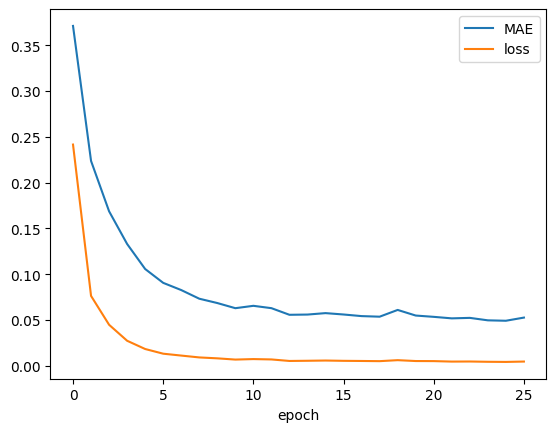

In [39]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()


In [66]:
#prepare all predictions
#lstm
print('single LSTM model')
msft_lstm_rmse, msft_lstm_mae = compute_metrics(target_scaler.inverse_transform(y_test),target_scaler.inverse_transform(LSTM_MSFT_test))
goog_lstm_rmse, goog_lstm_mae = compute_metrics(google_scaler.inverse_transform(google_target), google_scaler.inverse_transform(LSTM_GOOG_yhat))

print('single hybrid model')
#single hybrid
msft_single_rmse, msft_single_mae = compute_metrics(target_scaler.inverse_transform(MSFT_y_test), target_scaler.inverse_transform(MSFT_predictions))
goog_single_rmse, goog_single_mae = compute_metrics(google_scaler.inverse_transform(GOOG_y_test),google_scaler.inverse_transform(GOOG_predictions))

print('single linear model')
#Single linear hybrid
msft_sing_linear_rmse, msft_sing_linear_mae = compute_metrics(target_scaler.inverse_transform(y_test), target_scaler.inverse_transform(linear_predictions_MSFT))
goog_linear_rmse, goog_linear_mae = compute_metrics(google_scaler.inverse_transform(google_target), google_scaler.inverse_transform(linear_predictions_GOOG))

print('expanded hybrid model')
#expanded_hybrid
msft_expanded_rmse, msft_expanded_mae = compute_metrics(target_scaler.inverse_transform(msft_y), target_scaler.inverse_transform(msft_predictions))
goog_expanded_rmse, goog_expanded_mae = compute_metrics(google_scaler.inverse_transform(goog_y), google_scaler.inverse_transform(goog_predictions))

print('expanded linear model')
#Expanded linear hybrid
msft_exlin_rmse, msft_exlin_mae = compute_metrics(target_scaler.inverse_transform(y_test), target_scaler.inverse_transform(linear_ex_msft))
goog_exlin_rmse, goog_exlin_mae = compute_metrics(google_scaler.inverse_transform(google_target), google_scaler.inverse_transform(linear_ex_goog))

single LSTM model
the root mean square error of the predictions is 7.615692138671875, and the mean absolute error of the predictions is 6.42903995513916
the root mean square error of the predictions is 3.2601938247680664, and the mean absolute error of the predictions is 2.5254108905792236
single hybrid model
the root mean square error of the predictions is 35.89143753051758, and the mean absolute error of the predictions is 29.397554397583008
the root mean square error of the predictions is 6.462332725524902, and the mean absolute error of the predictions is 5.649616241455078
single linear model
the root mean square error of the predictions is 9.2505521774292, and the mean absolute error of the predictions is 7.914196968078613
the root mean square error of the predictions is 3.130459785461426, and the mean absolute error of the predictions is 2.3393213748931885
expanded hybrid model
the root mean square error of the predictions is 19.238271713256836, and the mean absolute error of the

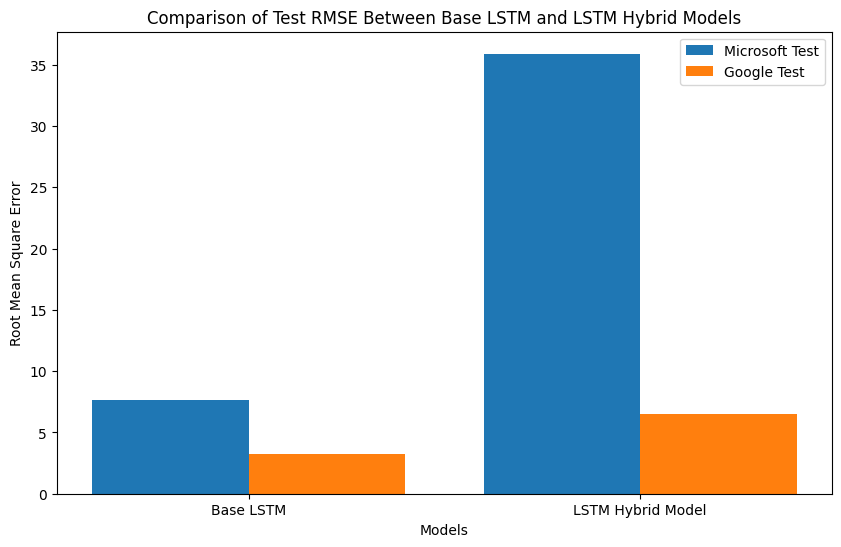

In [67]:
x = ['Base LSTM', 'LSTM Hybrid Model']
msft = [msft_lstm_rmse, msft_single_rmse]
goog = [goog_lstm_rmse, goog_single_rmse]
X_axis = np.arange(len(x))
plt.figure(figsize=(10, 6))
plt.bar(X_axis - 0.2, msft, 0.4, label = 'Microsoft Test')
plt.bar(X_axis + 0.2, goog, 0.4, label = 'Google Test')
plt.xticks(X_axis, x)
plt.xlabel("Models")
plt.ylabel("Root Mean Square Error")
plt.title("Comparison of Test RMSE Between Base LSTM and LSTM Hybrid Models")
plt.legend()
plt.show()

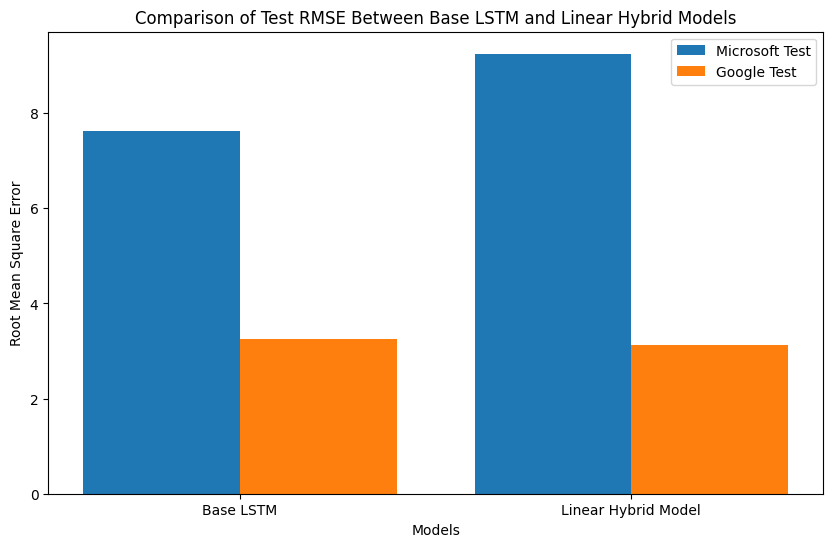

In [68]:
x = ['Base LSTM', 'Linear Hybrid Model']
msft = [msft_lstm_rmse, msft_sing_linear_rmse]
goog = [goog_lstm_rmse, goog_linear_rmse]
X_axis = np.arange(len(x))
plt.figure(figsize=(10, 6))
plt.bar(X_axis - 0.2, msft, 0.4, label = 'Microsoft Test')
plt.bar(X_axis + 0.2, goog, 0.4, label = 'Google Test')
plt.xticks(X_axis, x)
plt.xlabel("Models")
plt.ylabel("Root Mean Square Error")
#plt.ylim([0, 0.09])
plt.title("Comparison of Test RMSE Between Base LSTM and Linear Hybrid Models")
plt.legend()
plt.show()

[[51.86794079]]


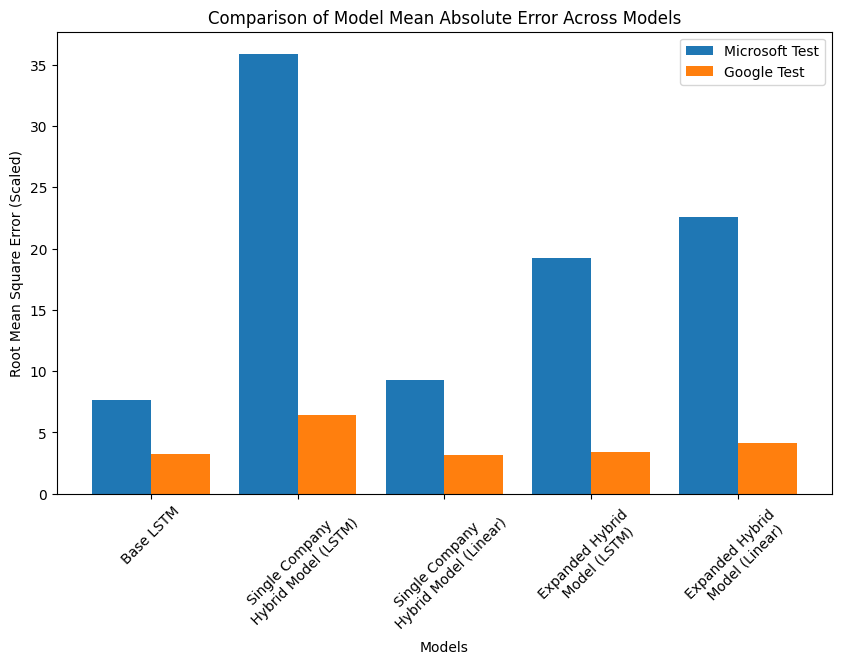

In [69]:
import seaborn as sns
x = ['Base LSTM', 'Single Company \n Hybrid Model (LSTM)', 'Single Company \n Hybrid Model (Linear)', "Expanded Hybrid \n Model (LSTM)", "Expanded Hybrid \n Model (Linear)"]
msft = [msft_lstm_rmse, msft_single_rmse, msft_sing_linear_rmse, msft_expanded_rmse, msft_exlin_rmse]
goog = [goog_lstm_rmse, goog_single_rmse, goog_linear_rmse, goog_expanded_rmse, goog_exlin_rmse]
X_axis = np.arange(len(x))
plt.figure(figsize=(10, 6))
plt.bar(X_axis - 0.2, msft, 0.4, label = 'Microsoft Test')
plt.bar(X_axis + 0.2, goog, 0.4, label = 'Google Test')


plt.xticks(X_axis, x)
plt.xlabel("Models")
plt.ylabel("Root Mean Square Error (Scaled)")
plt.title("Comparison of Model Mean Absolute Error Across Models")
plt.xticks(rotation = 45)
plt.legend()
plt.show()